In [11]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [12]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [13]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 100

In [14]:
with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{122}subjs_3.pkl','rb') as f:
        model,q,elbos,resampled_subj_list = pickle.load(f)

resampled_df = []
for pid in resampled_subj_list:
    resampled_df.append(orig_df[orig_df['pid']==pid])
resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

df = resampled_df

df['continuous_states'] = [None]*df.shape[0]
df['discrete_states'] =[None]*df.shape[0]
hrflag=0
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
    stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
    input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

    y = df.loc[idx_row]['timeseries']
    x = q.mean_continuous_states[idx_row]
    z = model.most_likely_states(x,y,input=input)
    df.at[idx_row,'continuous_states'] = x
    df.at[idx_row,'discrete_states'] = z
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df.at[idx_row,'proximity'] = prox

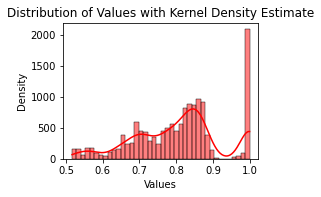

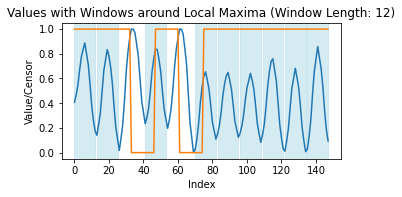

[0.6794047151426895, 0.7384231728842797, 0.7957315791716828, 0.834772383203685, 0.8611085001398832, 0.991641602975933]


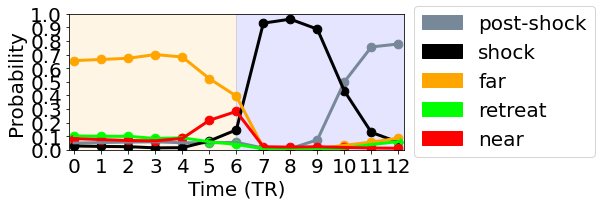

In [20]:
from scipy.signal import argrelextrema
colors = [to_rgba(c) for c in ['lightslategray','black','orange','lime','brown','red','blue','pink',]]
state_names = [f'State{i+1}' for i in range(K)]
state_names = ['post-shock','shock','far','retreat','???','near']

def find_windows_and_local_maxima(values, window_length, hrf_lag=0):
    """
    Finds windows centered at local maxima in a vector of values, with a given
    censor vector to indicate which indices can be used, and checks that all indices
    in the window are usable according to the censor variable. Returns the local maxima
    values corresponding to the windows.

    Args:
        values (numpy.ndarray): The vector of values.
        censor (numpy.ndarray): The censor vector indicating which indices can be used.
        window_length (int): The desired window length.

    Returns:
        list: A list of tuples representing the windows, where each tuple contains the start
              and end indices of the window.
        list: A list of local maxima values corresponding to the windows.
    """
    # Find the indices of the local maxima in the values vector
    local_maxima_indices = argrelextrema(values, np.greater)[0]

    # Initialize lists to store the windows and local maxima values
    windows = []
    local_maxima = []

    # Iterate through the local maxima indices
    for idx in local_maxima_indices:
        # Check if the window length can fit around the local maxima
        if idx - window_length // 2 + hrf_lag >= 0 and idx + window_length // 2 + hrf_lag < len(values) :
            # Get the window indices
            window_start = idx - window_length // 2 + hrf_lag
            window_end = idx + window_length // 2 + hrf_lag
            windows.append((window_start, window_end))
            local_maxima.append(values[idx])

    return windows, local_maxima

# Example usage:

# Find windows around local maxima and corresponding local maxima values
local_maxima_all = []
windows_all = []
states_all_windows = []
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]['proximity']
    censor = df.loc[idx_row]['censor'][:,0]
    states = df.loc[idx_row]['discrete_states']
    
    window_length = 12
    windows, local_maxima = find_windows_and_local_maxima(prox, window_length)
    local_maxima_all += local_maxima
    windows_all += windows
    states_all_windows += [states[l:r+1] for l,r in windows]

states_all_windows = np.vstack(states_all_windows)
local_maxima_all = np.array(local_maxima_all)


fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))

# Plot a distribution plot with kernel density estimate on the right subplot
sns.histplot(local_maxima_all, ax=ax, kde=True, kde_kws={'bw_method': 0.2}, color='r')  # Set color of KDE curve
ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.set_title('Distribution of Values with Kernel Density Estimate')

# Show the plot
plt.show()

# Plot the values, censor, and window lengths
plt.figure(figsize=(5, 2.5))
plt.plot(prox, label='Values')
plt.plot(censor, label='Censor')
for window in windows:
    plt.axvspan(window[0], window[1], color='lightblue', alpha=0.5, label='Window')
plt.xlabel('Index')
plt.ylabel('Value/Censor')
# plt.legend()
plt.title(f'Values with Windows around Local Maxima (Window Length: {window_length})')
plt.show()
ncols=1
local_maxima_bins = [np.quantile(local_maxima_all,i) for i in np.arange(0,1,1/7)[1:]]
print(local_maxima_bins)
bin_indices = np.digitize(local_maxima_all,bins=local_maxima_bins)
fig,axs = plt.subplots(nrows=1, ncols=ncols, figsize=(6,2.5), sharex=True, sharey=True)
proxbin=6
for i_bin in [proxbin]:#range(len(local_maxima_bins)+1):
    ax = axs
    # find states coresponding to all windows belonging to that bin
    z_bin = states_all_windows[bin_indices==i_bin,:]
    state_window_probs = np.stack(
        [np.array([(z_bin[:,tr]==k).sum() for k in range(model.K)])
          for tr in range(z_bin.shape[1])]
          ,axis=1)
    state_window_probs = state_window_probs / state_window_probs.sum(axis=0)
    
    ax.axvspan(-1,6,alpha=0.1, color='orange')
    ax.axvspan(6,13,alpha=0.1, color='blue')
    for k in [0,1,2,3,5]:
        ax.plot(state_window_probs[k,:],color=colors[k],label=state_names[k],linewidth=3)
        ax.scatter(np.arange(z_bin.shape[1]),state_window_probs[k,:],color=colors[k],s=75)
    ax.set_xticks(np.arange(z_bin.shape[1]))
    ax.set_xticklabels(np.arange(z_bin.shape[1]),fontsize=20,rotation=0)
    ax.set_yticks(0.1*np.arange(11))
    ax.set_xlim([0-0.2,z_bin.shape[1]-1+0.2])
    ax.set_ylim([0,1])
    ax.set_ylabel('Probability',fontsize=20)
    ax.set_xlabel('Time (TR)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    min_prox = min(local_maxima_all[bin_indices==i_bin])
    max_prox = max(local_maxima_all[bin_indices==i_bin])
    # ax.set_title(f'max proximity $\in$ ({min_prox:.02f},{max_prox:.02f}) ',fontsize=12)
patchs = []
import matplotlib.patches as mpatches

for state_name,color in zip(state_names,colors):
    if state_name != '???':
        patchs.append(mpatches.Patch(color=color, label=state_name))
# fig.delaxes(axs[ncols-1])
axs.legend(handles=patchs,fontsize=20,ncol=1,loc='right',bbox_to_anchor=(1.6, 0.5))
fig.savefig(f'figures/fig_approach_retreat_state_count_K{model.K}_proxbin{proxbin}.jpeg',dpi=600,bbox_inches='tight')